Dependencies and Setup

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests, time
from scipy.stats import linregress
from citipy import citipy  # Incorporated citipy to determine city based on latitude and longitude
# Import API key
from config import weather_api_key as api_key
from iso3166 import countries_by_alpha2  # pip install iso3166

sns.set(rc={'figure.dpi': 300, 'savefig.dpi': 300})
sns.set_context('notebook')


def k_to_f(temp):
    temp = round((temp - 273.15) * 9 / 5 + 32, 2)
    return temp


def kmh_to_mph(speed):
    return speed * 0.621371


def north_or_south(latitude):
    return latitude < 0


# output file
output_file = "cities.csv"

Range of latitudes and longitudes

In [2]:
lat_range = (-90, 90)
lng_range = (-180, 180)

lats = [np.random.uniform(lat_range[0], lat_range[1]) for i in range(3000)]
lngs = [np.random.uniform(lng_range[0], lng_range[1]) for i in range(3000)]

lat_lngs = list(zip(lats, lngs))

cities = []

for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    city = city.strip()
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

print(len(cities))

995


In [3]:
temp_dict = {}
# {city:[lat, max_temp, humidity, windspeed, clouds]}
i, j = 0, 0

for city in cities:
    if i < 500:
        search_str = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}'
        resp = requests.get(search_str)
        if resp.status_code == 200:
            resp = resp.json()
            vs = [
                    resp['coord']['lat'],
                    k_to_f(resp['main']['temp_max']),
                    resp['main']['humidity'],
                    kmh_to_mph(resp['wind']['speed']),
                    resp['clouds']['all']
            ]
            temp_dict[city] = vs
            i += 1
            print(f'Request {j}: {city} request successful.')
        else:
            print(f'Request {j}: {city} request failed.')
        j += 1
    else:
        print(
                f'{i} successful requests made.\n'
                f'{round(i / j * 100, 2)}% of requests succeeded.'
        )
        break

Request 0: saskylakh request successful.
Request 1: russell request successful.
Request 2: bambous virieux request successful.
Request 3: new norfolk request successful.
Request 4: vaini request successful.
Request 5: hobart request successful.
Request 6: severo-kurilsk request successful.
Request 7: burica request failed.
Request 8: cabo san lucas request successful.
Request 9: ji-parana request failed.
Request 10: asau request successful.
Request 11: butaritari request successful.
Request 12: leningradskiy request successful.
Request 13: east london request successful.
Request 14: albany request successful.
Request 15: kapaa request successful.
Request 16: ushuaia request successful.
Request 17: thompson request successful.
Request 18: attawapiskat request failed.
Request 19: taolanaro request failed.
Request 20: iisalmi request successful.
Request 21: esmeraldas request successful.
Request 22: matara request successful.
Request 23: kawalu request successful.
Request 24: nuuk request

In [8]:
dft = pd.DataFrame(temp_dict).T
dft.columns = ['Latitude', 'Max Temperature (F)', 'Humidity (%)', 'Wind Speed (mph)', 'Clouds (%)']
dft['is_south'] = dft['Latitude'].apply(lambda x: 1 if x < 0 else 0)
dft.head()

dft.to_csv(output_file)

In [187]:
df_north = dft[dft['is_south'] == 0].copy()
df_south = dft[dft['is_south'] == 1].copy()


def make_figures(df, name=None, x='Latitude', y=None, hue_by=None):
    sns.scatterplot(
            x=x,
            y=y,
            data=df,
            hue=hue_by,
            palette='magma',
            alpha=0.8,
            edgecolor='b',
            legend=False
    )

    if name is not None:
        title = f'{name.title()} - {y} vs {x}'
    else:
        title = f'{y} vs. {x}'

    plt.title(title)
    plt.savefig(f'{title}.png')
    plt.close()
    return



In [188]:
ys = ['Max Temperature (F)', 'Humidity (%)', 'Wind Speed (mph)', 'Clouds (%)']

for y in ys:
    make_figures(dft, y=y, hue_by=dft['is_south'])


In [37]:
# if only :)
# import plotly.express as px
#
# fig = px.scatter(
#         df_north,
#         x='Latitude',
#         y=ys[0],
#         trendline='ols'
# )
# fig.show()
#
# reg = px.get_trendline_results(fig)
# reg.query().px_fit_results.iloc[0].summary()

# def scatter_trend(df, name=None, x='Latitude', y=None, hue_by=None):

#     fig = px.scatter(
#             df,
#             x=x,
#             y=y,
#             trendline='ols',
#             color=hue_by
#     )
#
#     plt.savefig(f'{name}.png')
#     plt.show()
#     plt.close()
#     return

# fig = scatter_trend(df_north, name='north', y='Max Temperature (F)')
# plt.show()


TypeError: 'numpy.ndarray' object is not callable

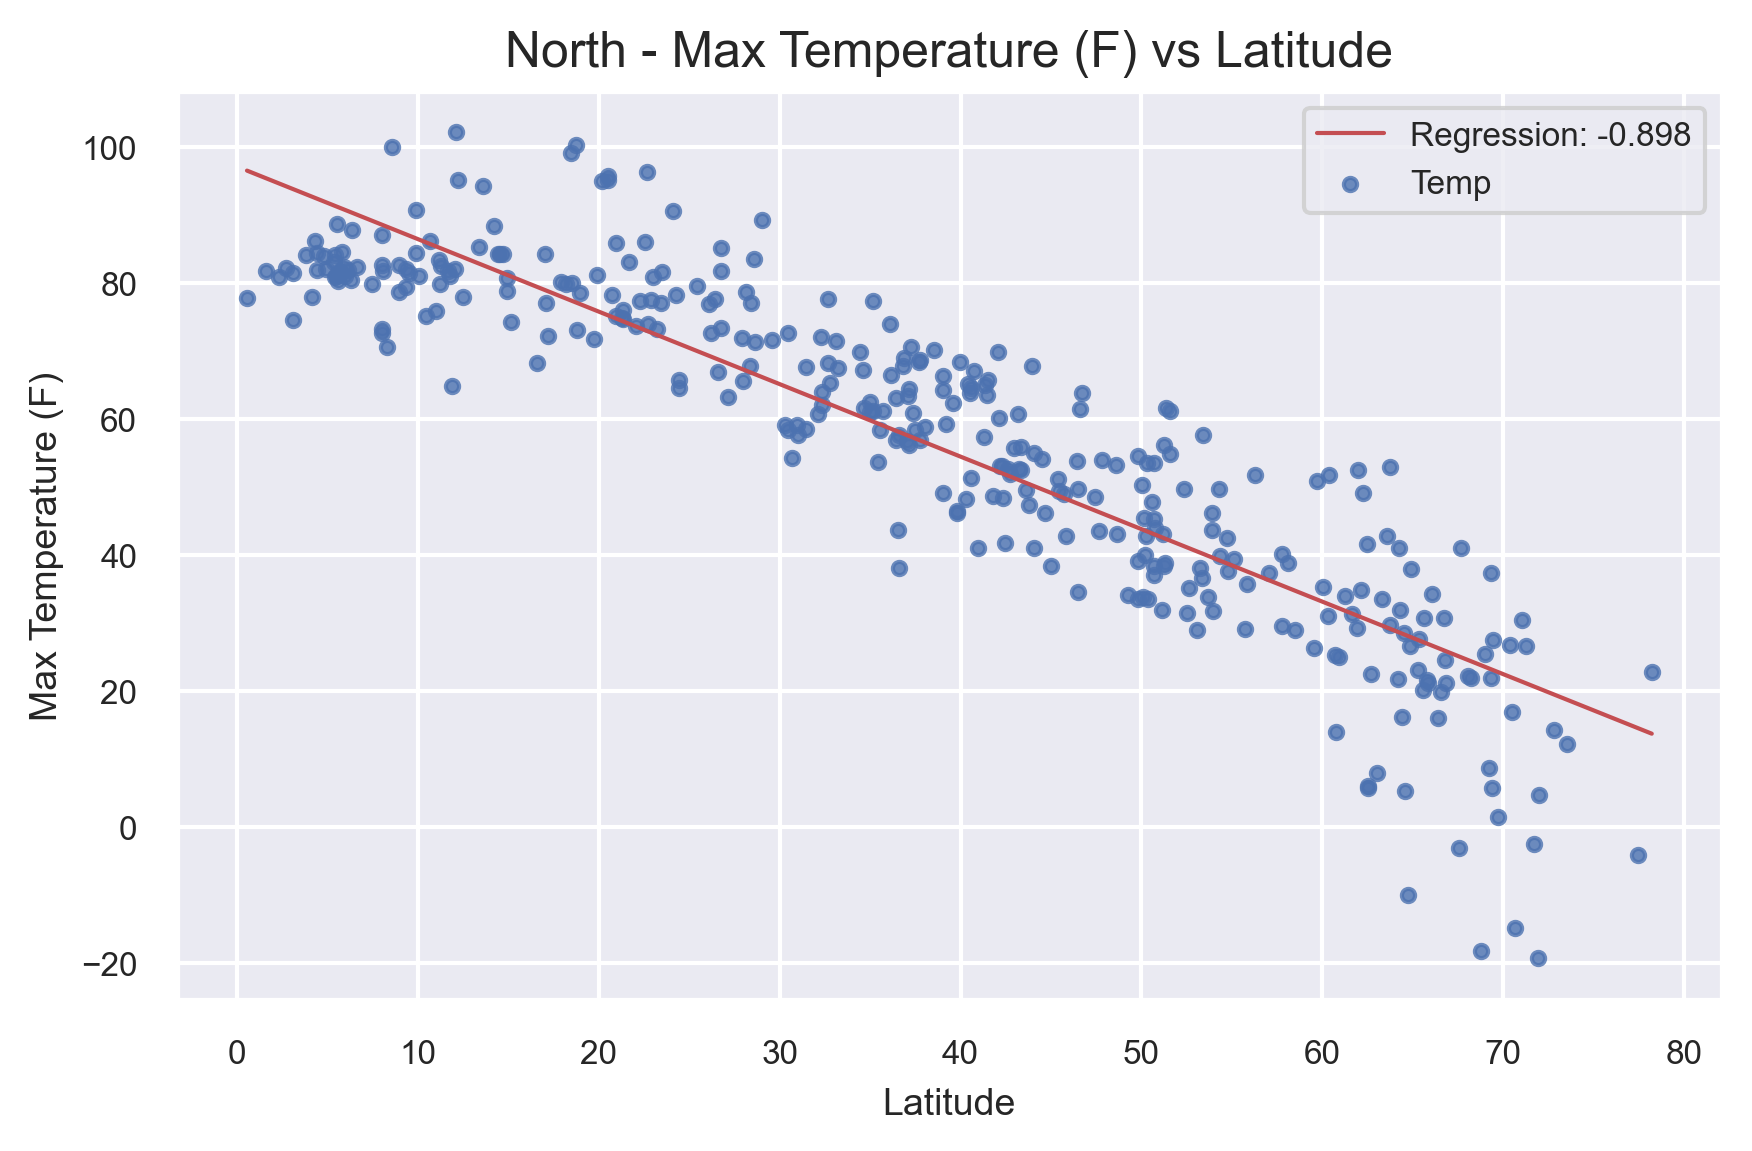

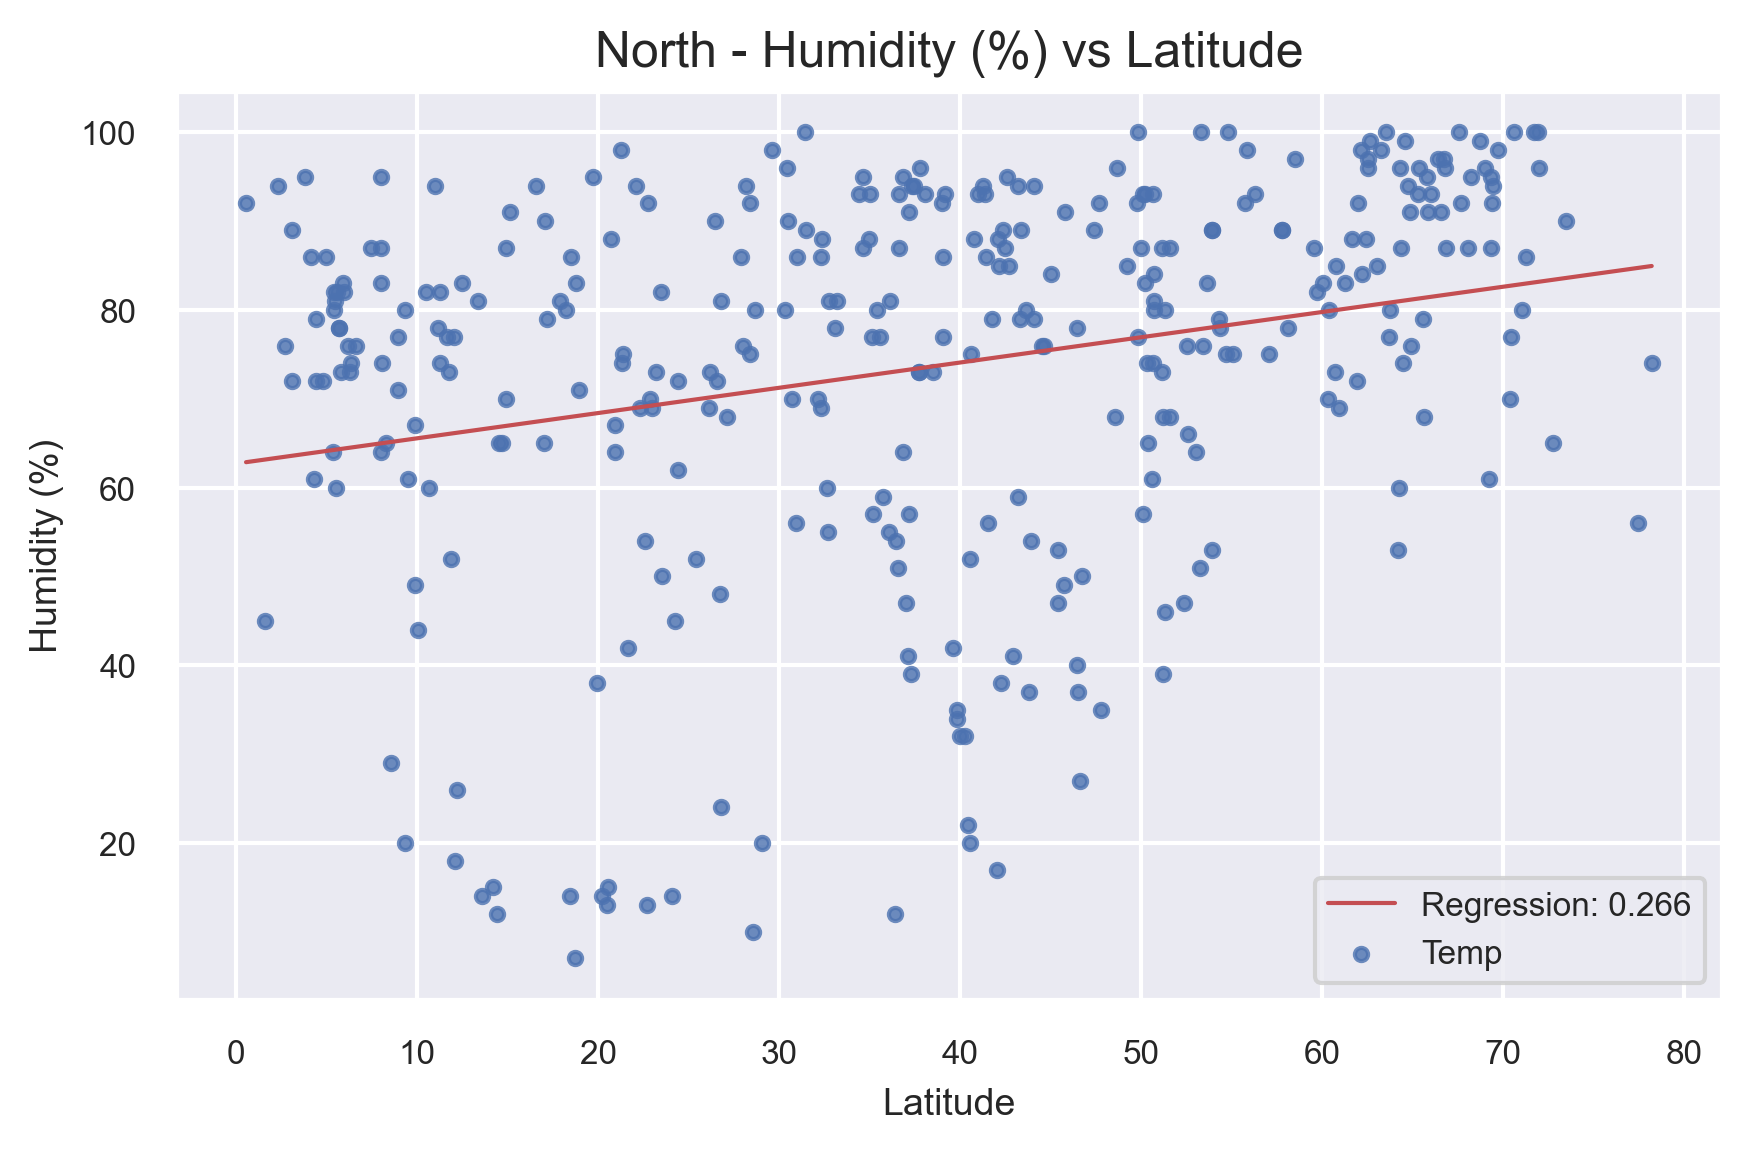

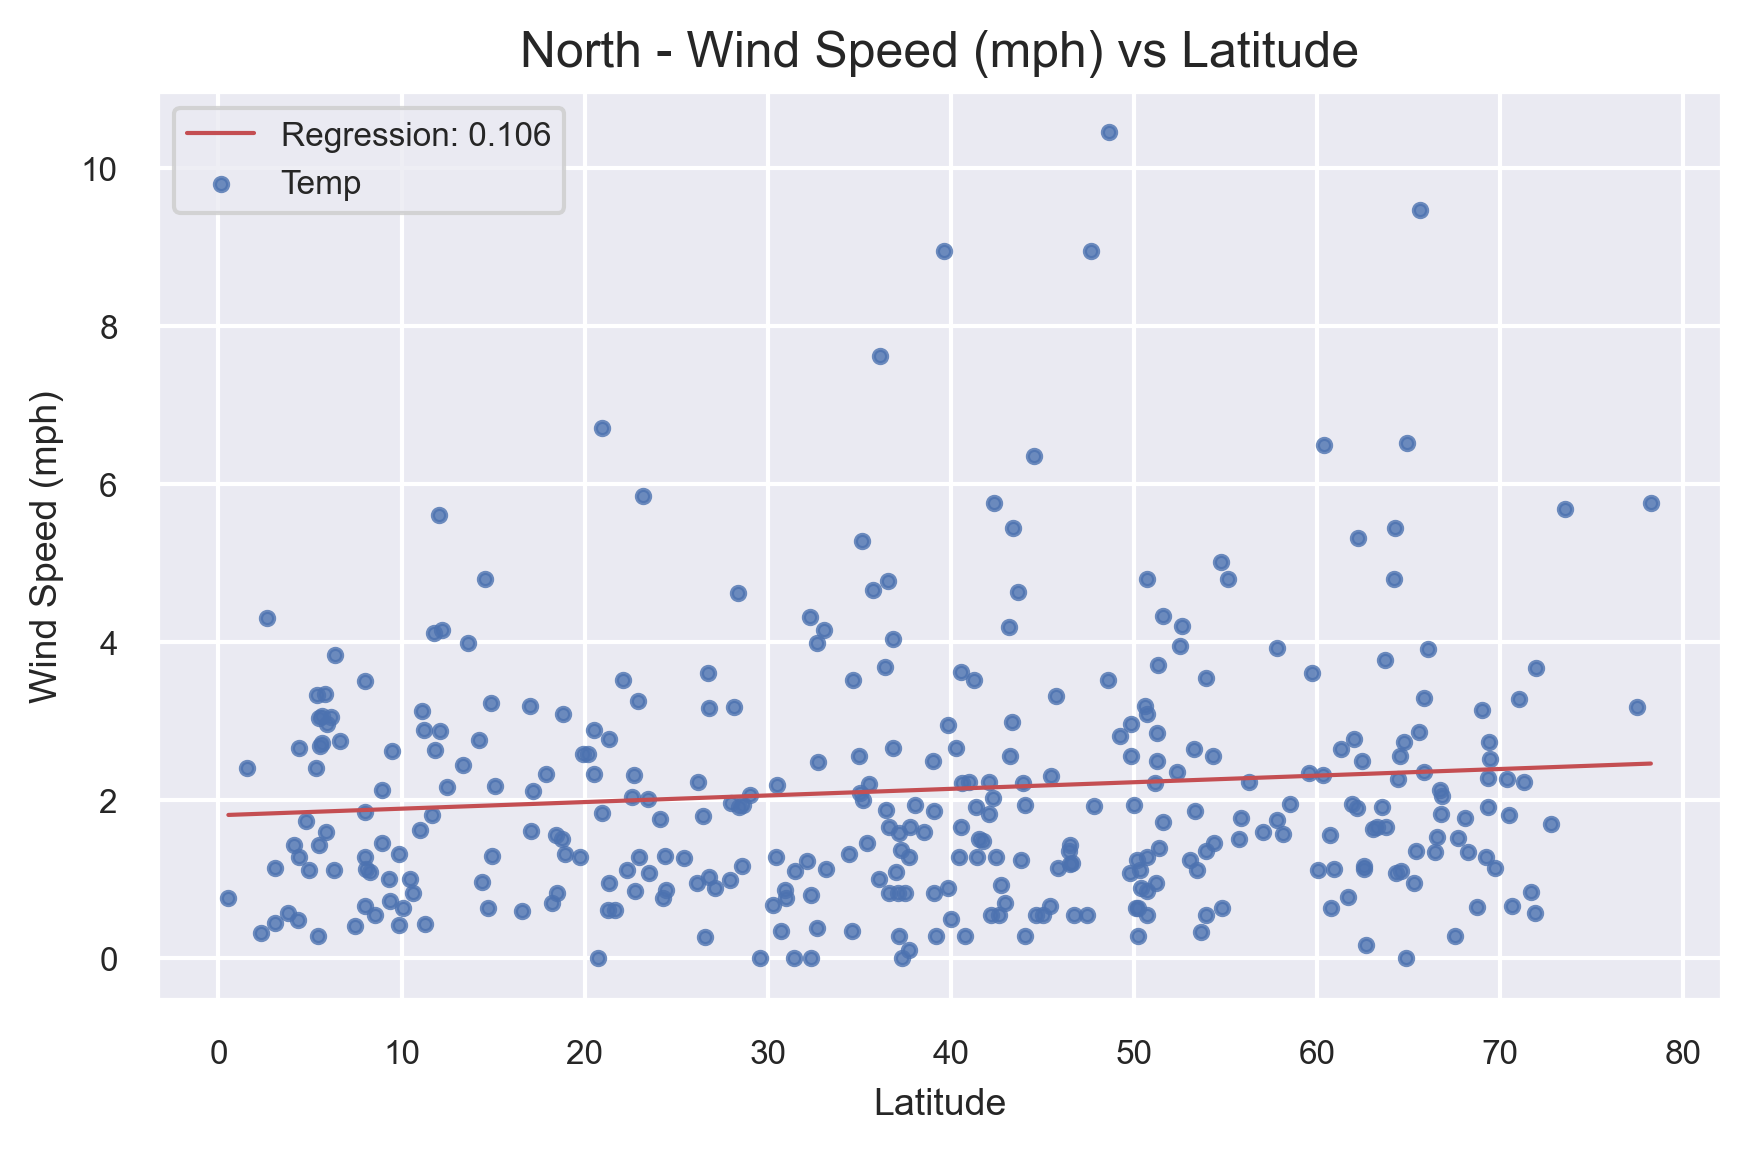

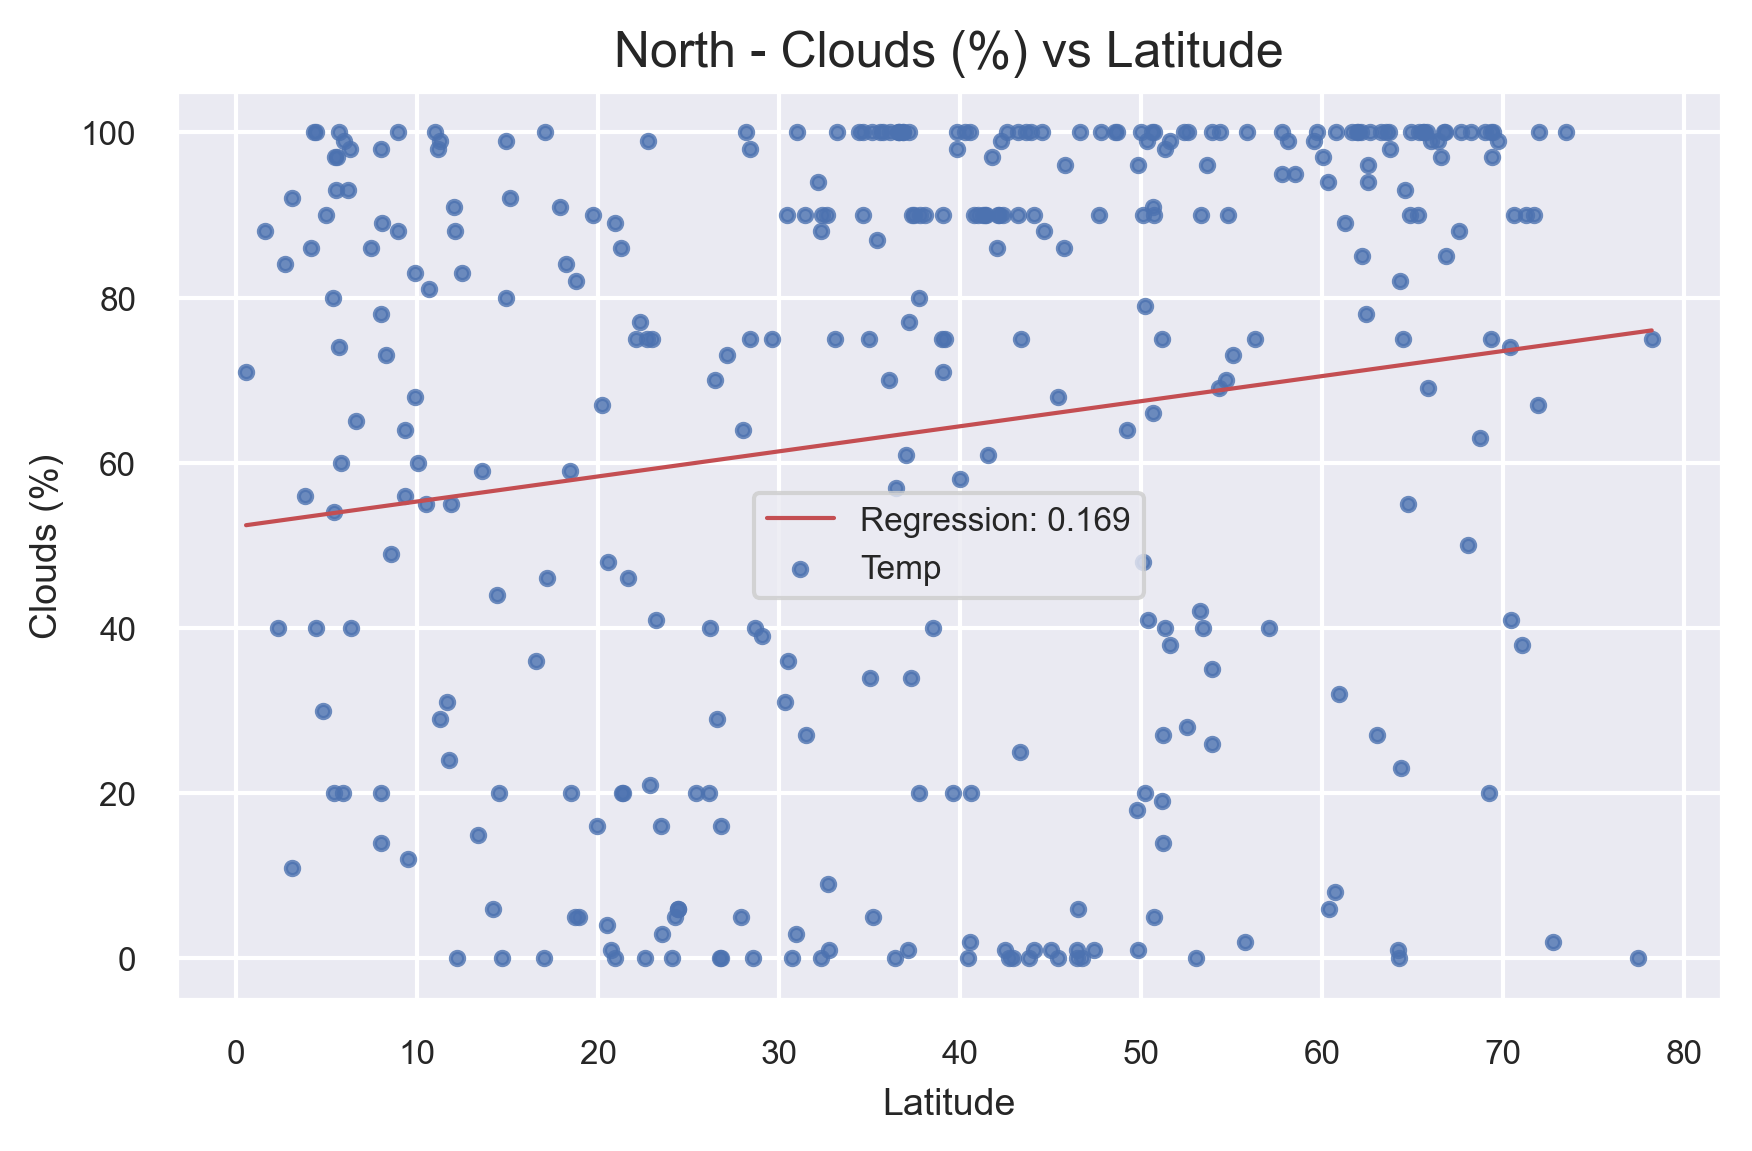

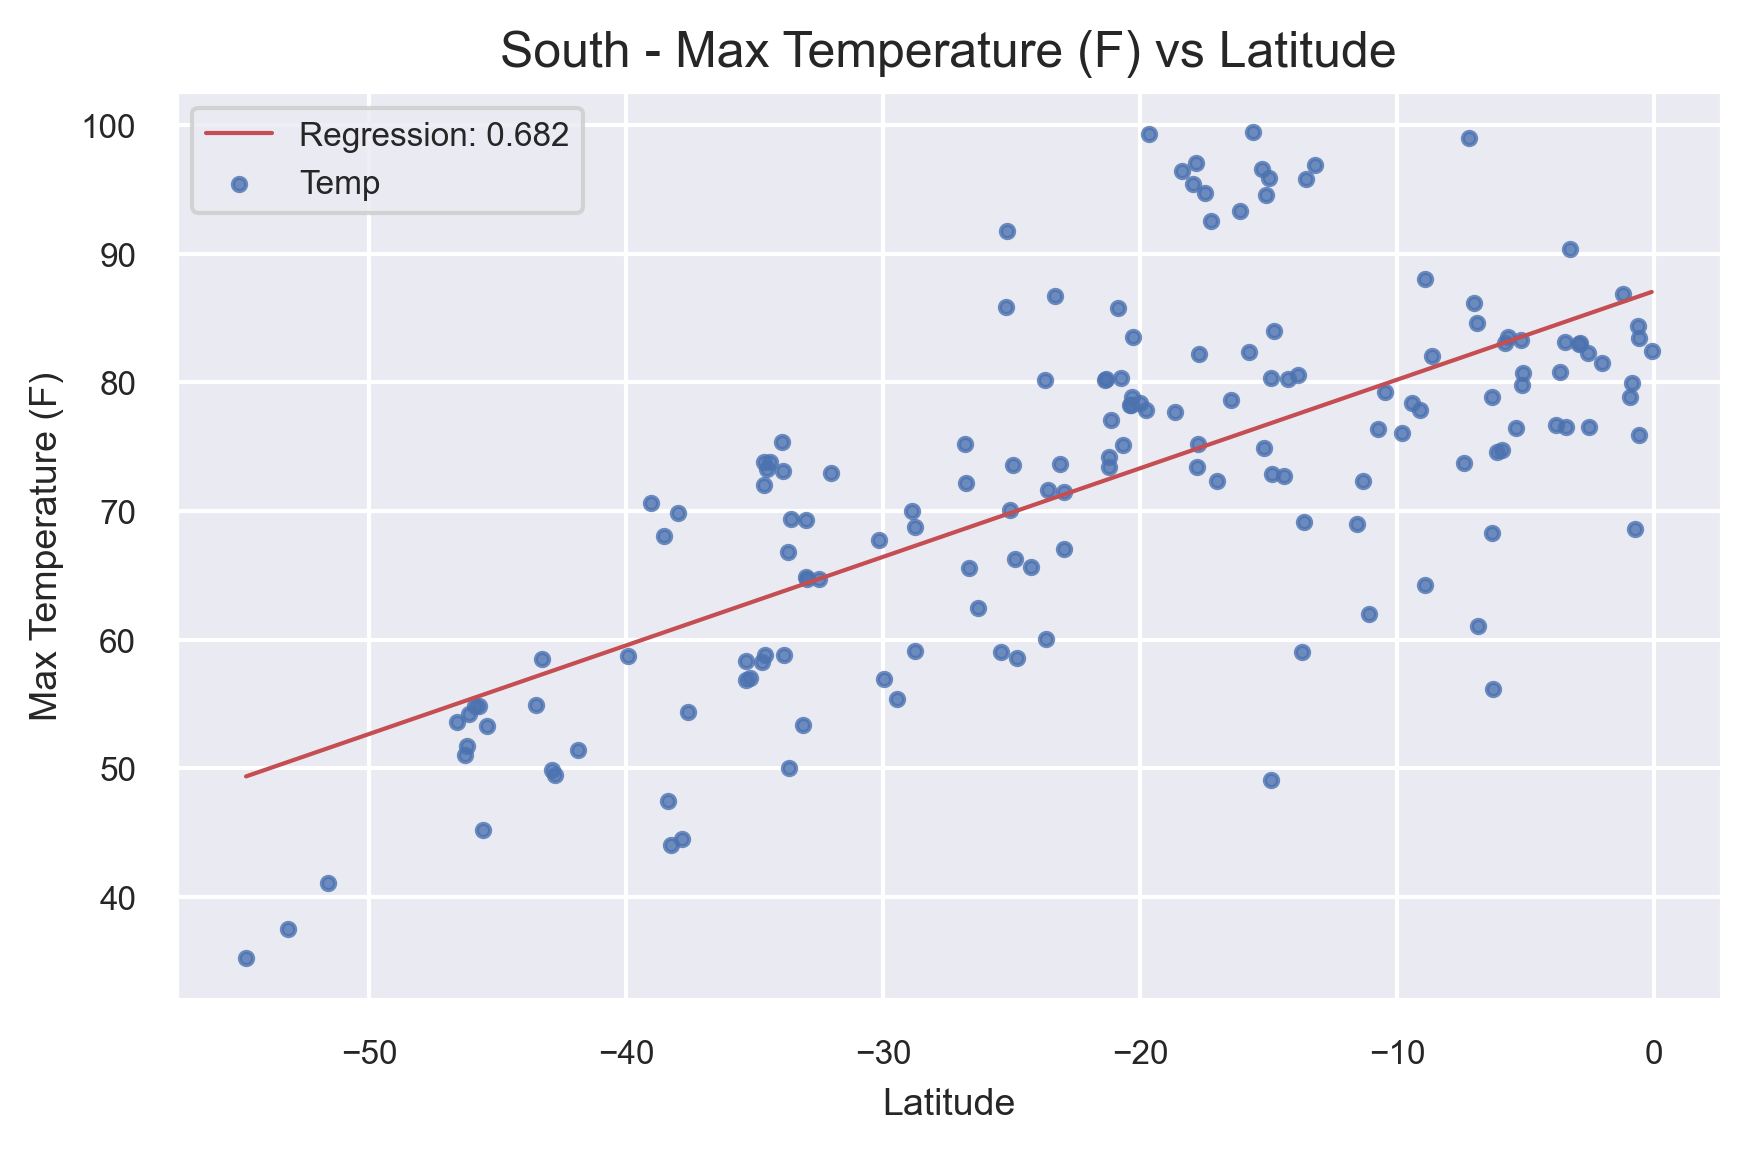

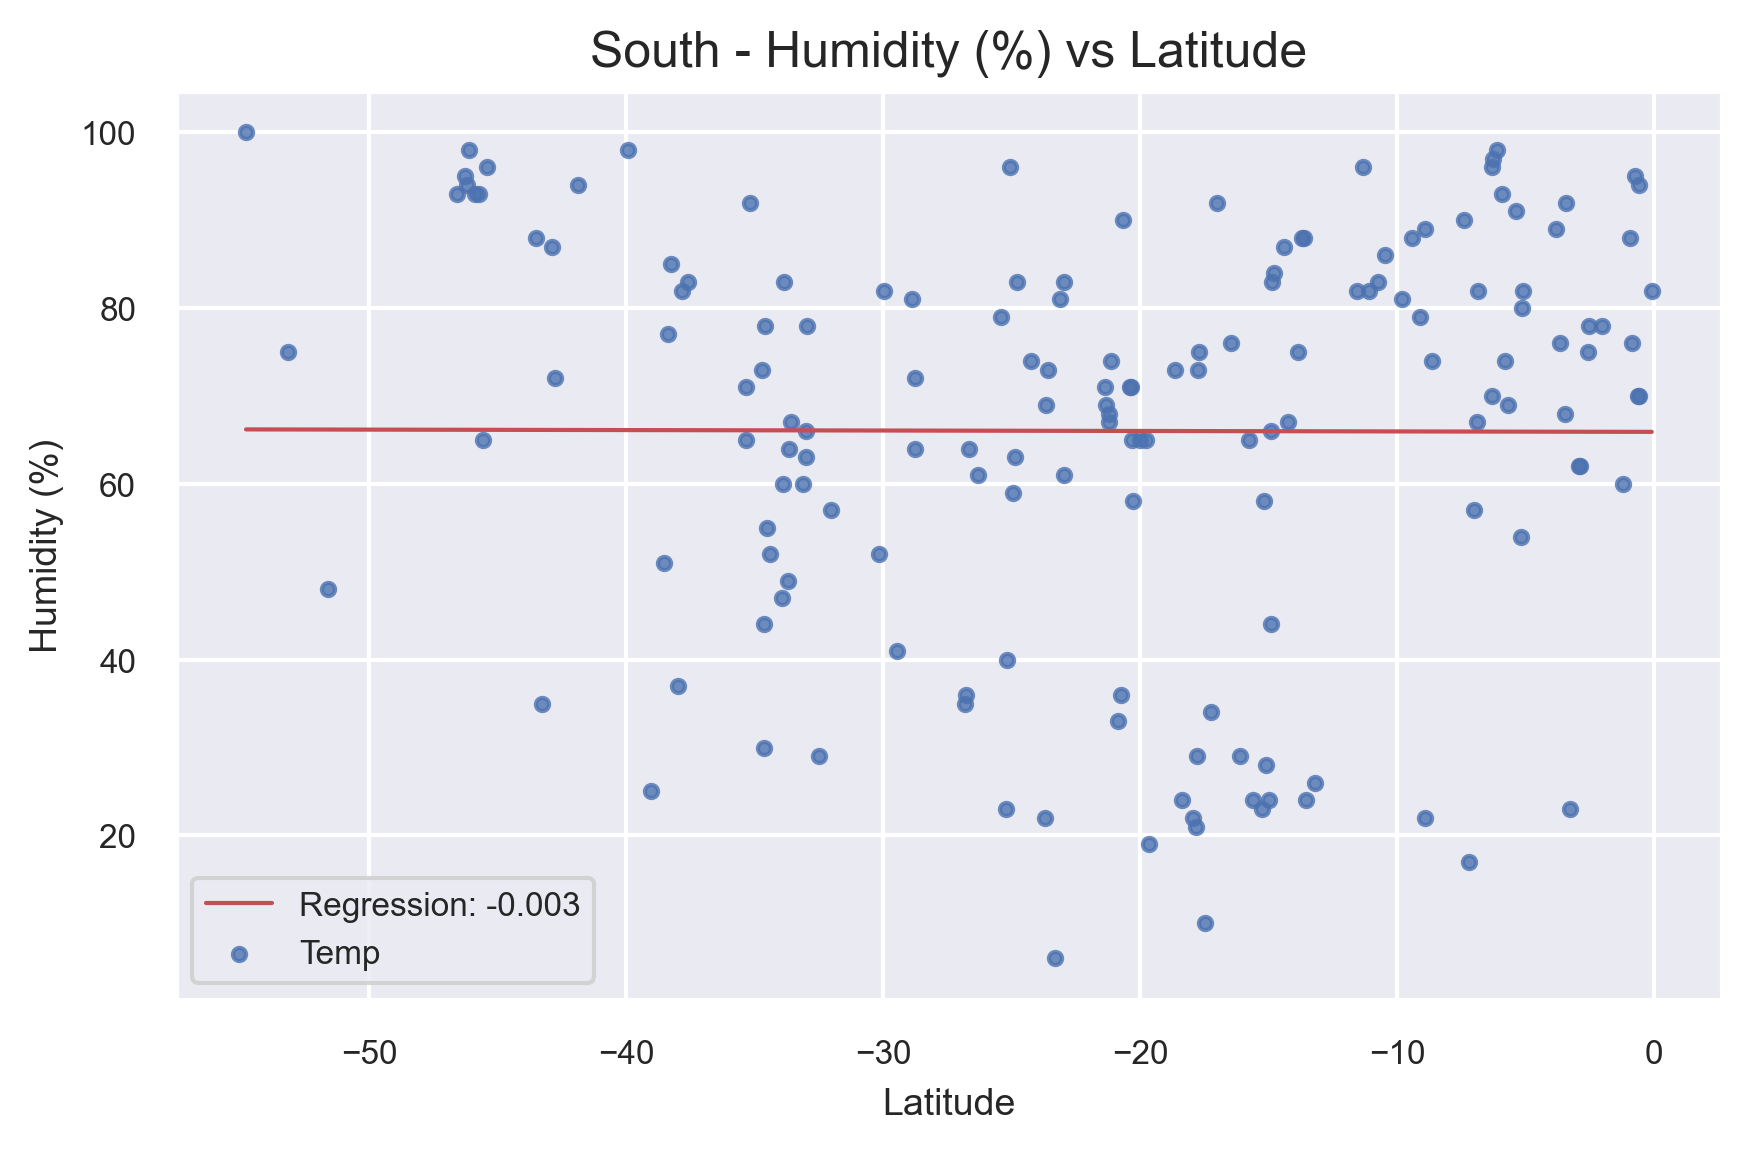

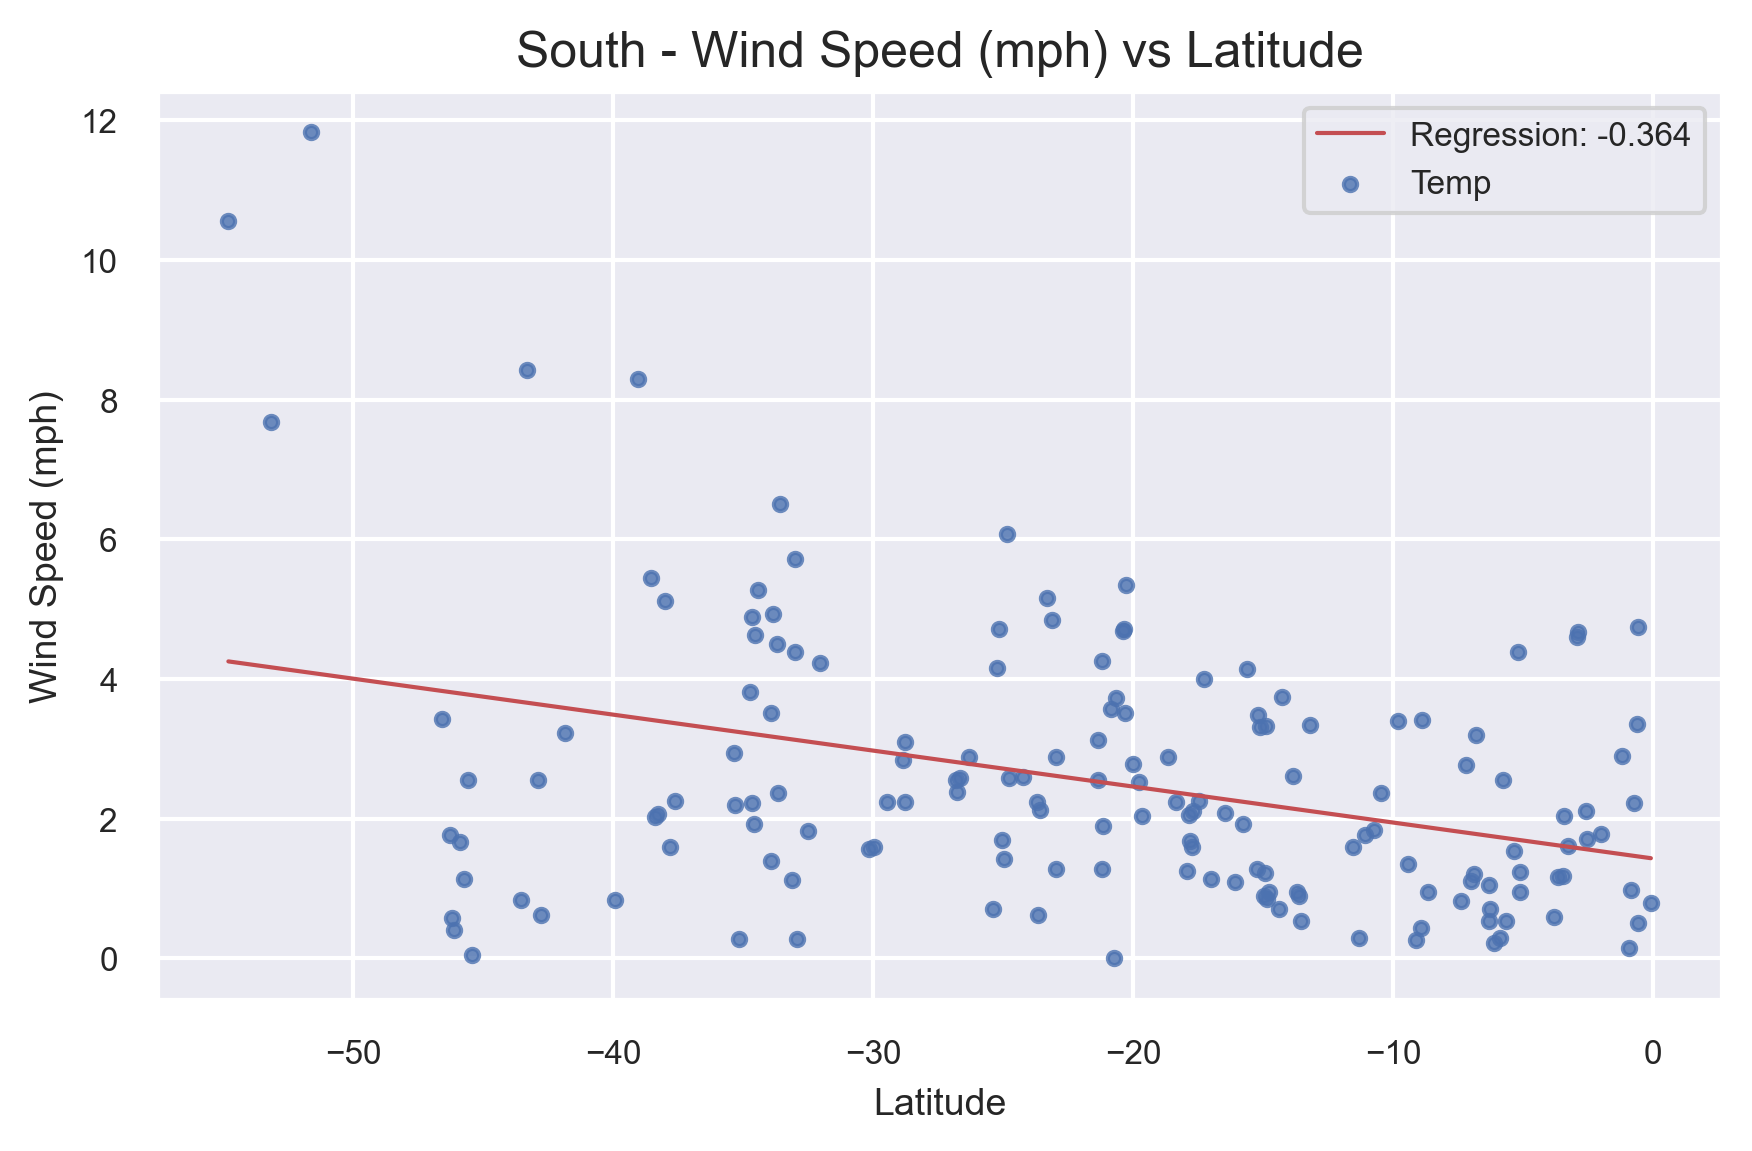

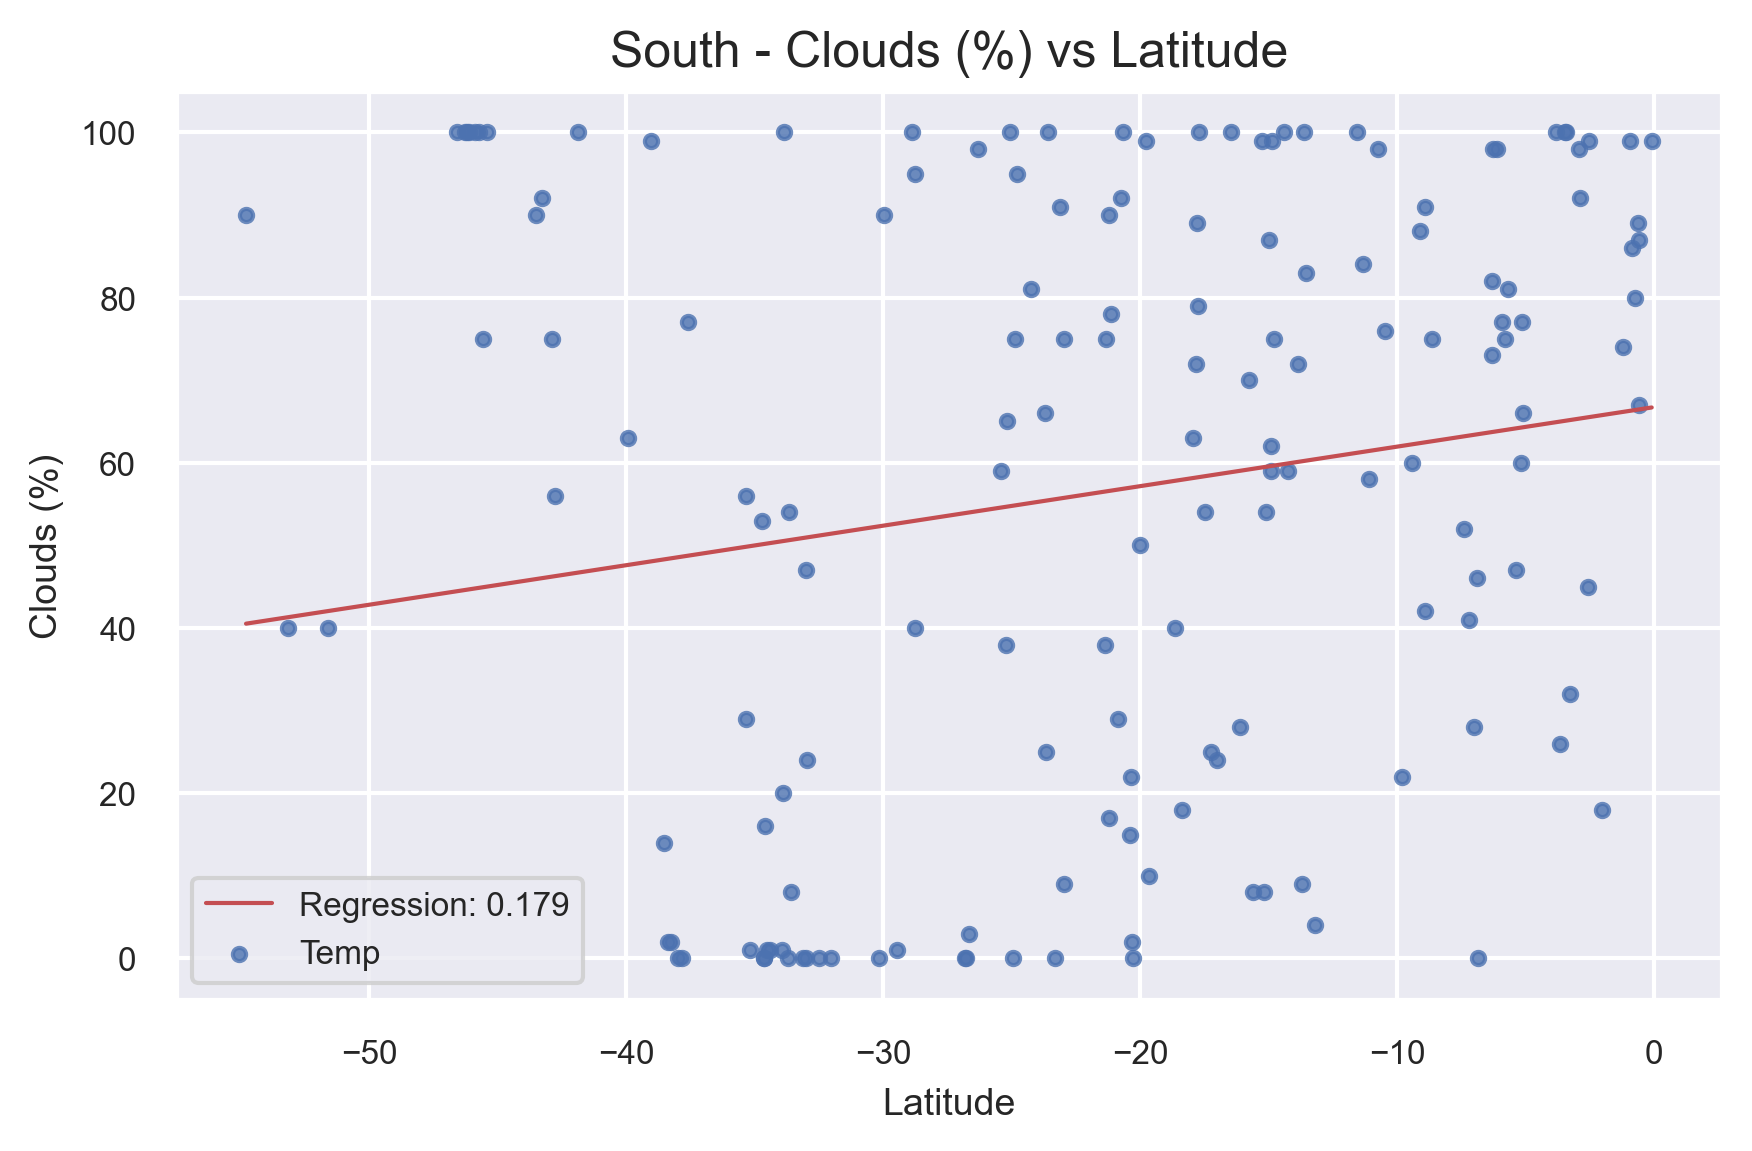

In [194]:
def make_figures_reg(df, name, x='Latitude', y=None):
    reg_vals = linregress(df[x], df[y])

    sns.regplot(
            x=x,
            y=y,
            data=df,
            scatter=True,
            fit_reg=True,
            ci=None,
            # label='Max Temperature (F) vs. Latitude',
            scatter_kws={
                    's': 10,
                    'alpha': 0.8
            },
            line_kws={
                    'color': 'r',
                    'lw': 1,
                    'label': f'Regression: {reg_vals[2]}'
            }
    )

    title = f'{name.title()} - {y} vs {x}'

    plt.xlabel(x, fontsize=9)
    plt.xticks(fontsize=8)
    plt.ylabel(y, fontsize=9)
    plt.yticks(fontsize=8)


    plt.title(title)
    plt.legend([f'Regression: {round(reg_vals[2],3)}', 'Temp'], fontsize='8')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{title}.png')
    plt.close()
    return


dfs = [df_north, df_south]
names = ['North', 'South']
ys = ['Max Temperature (F)', 'Humidity (%)', 'Wind Speed (mph)', 'Clouds (%)']

for name, frame in zip(names, dfs):
    for y in ys:
        make_figures_reg(frame, name, y=y)

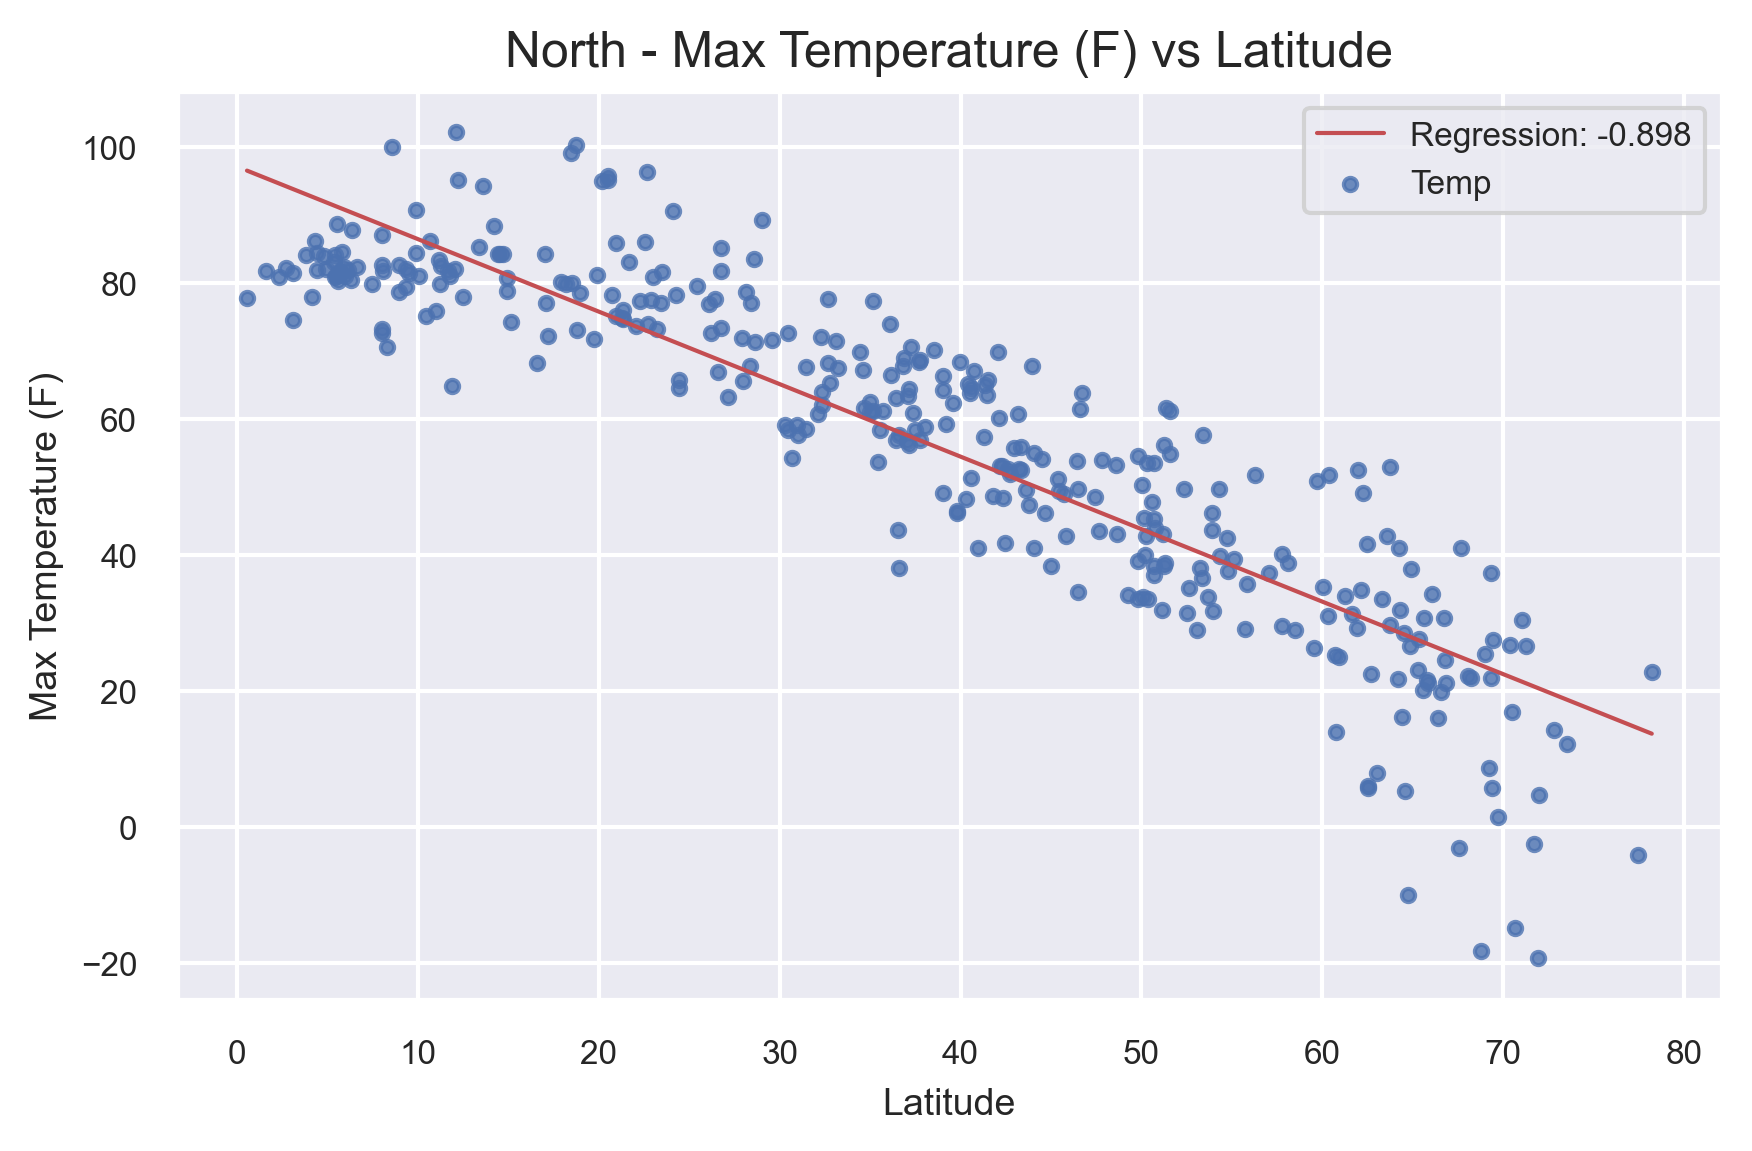

In [193]:
make_figures_reg(df_north, 'North', y=ys[0])